# GALAH Age vs. [Na/Fe]

Inspired by Nissen et al. (2020):
https://ui.adsabs.harvard.edu/abs/2020A&A...640A..81N


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import matplotlib.colors as colors
import matplotlib
import os
import matplotlib.patches as mpatches
import pickle
import sys
import scipy
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

In [2]:
#AdditioNa_l libaries
from scipy.optimize import curve_fit
from astropy.table import Table,join
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
from scipy.io import readsav
from mpl_toolkits import mplot3d
from scipy import stats
from scipy.ndimage import convolve
from pathlib import Path
from matplotlib.gridspec import GridSpec
from scipy.stats import kde
from scipy.stats import gaussian_kde
from scipy.stats import linregress
from numpy import percentile
from astropy.io import fits
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde as kde
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator
from scipy.ndimage import gaussian_filter

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# try:
#     %matplotlib inline
#     %config InlineBackend.figure_format='retina'
# except:
#     pass

# # Basic packages
# import numpy as np
# import astropy.units as u
# from astropy.table import Table, join
# from astropy.io import fits
# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import sys
# from scipy.optimize import curve_fit
# import warnings
# from scipy import stats

# warnings.filterwarnings('ignore')
# %matplotlib inline
# %config InlineBackend.figure_format='retina' 

# Import our data: GALAH DR3 + Nissen (2020)

In [4]:
try:
    spec = Table.read(r'/Users/evansowusu/PhD_Files/Galah_Data/GALAH_DR3_main_allstar_v2.fits')
    age = Table.read(r'/Users/evansowusu/PhD_Files/GALAH_Data/GALAH_DR3_VAC_ages_v2.fits')
    spec_age_join = join(spec, age, keys='sobject_id')
    dynamics = Table.read(r'/Users/evansowusu/PhD_Files/GALAH_Data/GALAH_DR3_VAC_dynamics_v2.fits')
    galah = join(spec_age_join, dynamics, keys='sobject_id')
except:
    spec = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
    age = Table.read('data/GALAH_DR3_VAC_ages_v2.fits')
    spec_age_join = join(spec, age, keys='sobject_id')
    dynamics = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
    galah = join(spec_age_join, dynamics, keys='sobject_id',metadata_conflicts='silent')

In [5]:
nissen1 = Table.read('/Users/evansowusu/PhD_Files/GALAH_Data/Nissen2020A&A...640A..81N.fits',1)
nissen2 = Table.read('/Users/evansowusu/PhD_Files/GALAH_Data/Nissen2020A&A...640A..81N.fits',2)
nissen_both = join(nissen1, nissen2, keys = 'HD',metadata_conflicts='silent')
young = nissen_both['Age'] < 5 - 3*nissen_both['__Fe_H_']
old = nissen_both['Age'] > 6 - 3*nissen_both['__Fe_H_']
neither = (~young) & (~old)

# Basic Selection Cuts

In [6]:
solar_type = (
    (galah['snr_c2_iraf'] > 50) & 
    (galah['flag_sp'] == 0) &
    (galah['flag_fe_h'] == 0) &
    (galah['teff'] > 5600) & (galah['teff'] < 5950) &
    (galah['logg'] > 4.15) &
    (galah['fe_h'] > -0.3) &
    (galah['fe_h'] < 0.3) &
    (galah['flag_Na_fe'] == 0) &
    (
        (galah['e_age_bstep'] / galah['age_bstep'] < 0.2) | 
        (galah['e_age_bstep'] < 2)
    )
)

old_sequence = (
    solar_type & 
    (galah['Na_fe'] > 0.55 - 0.5/5.5 * galah['age_bstep'])
)

young_sequence = (
    solar_type & 
    (galah['Na_fe'] <= 0.55 - 0.5/5.5 * galah['age_bstep'])
)


selection_finite_ages = (
    np.isfinite(galah['age_bstep'])
)

selection_na = (
    (galah['flag_sp'] == 0) &
    (galah['flag_fe_h'] == 0) & 
    (galah['flag_Na_fe'] == 0)
)

In [7]:
# elements = [
#     #'Li',
#     'C','O',
#     'Na','Mg','Al','Si',
#     'K','Ca','Sc',#'Sc2',
#     'Ti','Ti2',
#     'V','Cr','Mn','Co','Ni','Cu','Zn',
#     #'Rb','Sr',
#     'Y',#'Zr','Mo','Ru',
#     'Ba','La',
#     #'Ce','Nd','Sm','Eu'
# ]
elements = ['C', 'O', 'Na', 'Mg', 
            'Al', 'Si', 'K', 'Ca', 
            'Sc', 'Ti', 'Ti2', 'V', 'Cr', 
            'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 
             'Ba', 'La']

In [8]:
# nrows = 3; ncols = 7
# f, gs = plt.subplots(nrows,ncols,figsize=(15,7.5))

# for each_index, each_element in enumerate(elements):
    
#     row = int(np.floor(each_index/ncols))
#     col = each_index - ncols*row
    
#     xfe_range=[-0.4,0.5]
    
#     ax = gs[row,col]
#     plot_xfe_vs_age(ax=ax, each_element=each_element,xfe_range=xfe_range,age_bins = np.linspace(.0,12.5,50))
    
#     if row == 2:
#         ax.set_xlabel('Age [Gyr]',fontsize=15)
#     else:
#         ax.set_xticks([])
#     if col == 0:
#         ax.set_ylabel('[X/Fe]',fontsize=15)
#     else:
#         ax.set_yticks([])
        
#     if each_element not in ['Li','K','Sc','Sc2','Ti2','V','Mn','Co','Cu','Zn','Rb','Sr','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
#         ax.scatter(
#             nissen_both['Age'][neither],
#             nissen_both['__'+each_element+'_Fe_'][neither],
#             c = 'k',s=15
#         )
#         ax.scatter(
#             nissen_both['Age'][old],
#             nissen_both['__'+each_element+'_Fe_'][old],
#             c = 'r',s=15
#         )
#         ax.scatter(
#             nissen_both['Age'][young],
#             nissen_both['__'+each_element+'_Fe_'][young],
#             c = 'b',s=15
#         )
#     ax.text(0.05,0.95,each_element,transform=ax.transAxes,ha='left',va='top',fontsize=15,bbox=dict(boxstyle='round', facecolor='w'))
#     ax.set_xlim(13.5,0)

# plt.tight_layout(w_pad=0,h_pad=0)
# #plt.savefig('figures/age_abundance.png',dpi=200,bbox_inches='tight')

In [9]:
latexpath ='/Users/evansowusu/Research/disc_paper_V_1.0/6361e47283deef812e1ca3db/'

In [10]:
def plot_xfe_vs_age(ax, selection,each_element, xfe_range=[-0.5,1.5], age_bins = np.linspace(0,12.5,50)):

    age = galah['age_bstep'][selection]
    xfe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        age,
        xfe,
        bins = (
            age_bins,
            np.linspace(xfe_range[0],xfe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )
    
    try:
        difference = xfe - solar_twin_trend_function(age,each_element)

        ax.plot(age_bins,solar_twin_trend_function(age_bins,each_element),c='orange')
    
        ax.set_ylim(xfe_range[0],xfe_range[1])
        props = dict(boxstyle='round', facecolor='w')
        perc = np.percentile(difference,q = [16,40,84])
        ax.text(0.05,0.95,each_element+r': $'+"{:.3f}".format(perc[1])+'_{-'+"{:.3f}".format(perc[1]-perc[0])+'}^{+'+"{:.3f}".format(perc[2]-perc[1])+'}$',transform=ax.transAxes,va='top', bbox=props)
    except:
        pass

In [32]:
def plot_2dhist_fe_h_vs_Na_fe_colored_by_age(selection, ax, minimum_number_per_bin=3):
    """
    Plot 2d-hist bin for [Fe/H] vs. [Na/Fe] colored by median BSTEP age
    
    Input:
    selection : mask that will down-select entries from galah
    selection_title : title that will be given to figure
    """ 
    bs2d_counts = stats.binned_statistic_2d(
        x = galah['fe_h'][(selection & (galah['flag_'+element+'_fe']==0))],
        y = galah['Na_fe'][(selection& (galah['flag_'+element+'_fe']==0))],
        values = galah['age_bstep'][(selection& (galah['flag_'+element + '_fe']==0))],
        statistic='count',
        bins = (np.linspace(-1.5,0.75,100),np.linspace(-0.25,0.5,100))
    )    
    bs2d_output = stats.binned_statistic_2d(
        x = galah['fe_h'][selection],
        y = galah['Na_fe'][selection],
        values = galah['age_bstep'][selection],
        statistic='median',
        bins = (np.linspace(-1.5,0.75,100),np.linspace(-0.25,0.5,100))
    )
    bs2d_output.statistic[bs2d_counts.statistic < minimum_number_per_bin] = np.NaN

    img = ax.imshow(
        bs2d_output.statistic.T, 
        origin = 'lower', 
        extent = [bs2d_output.x_edge[0], bs2d_output.x_edge[-1], bs2d_output.y_edge[0], bs2d_output.y_edge[-1]],
        cmap = 'RdYlBu_r',
        aspect = 'auto'
    )
    ax.plot(0,0, marker='$\odot$',color='black',markersize=15, label='Sun', ls='None')
    ax.legend(loc='lower left',fontsize=15,frameon=True, framealpha=1, edgecolor='black', handlelength=1.5)
    ax.set_xlabel('[Fe/H][dex]',fontsize=18)
    cbar = plt.colorbar(img, ax=gs[2])
    cbar.set_label('Median BSTEP Age [Gyr]',fontsize=18)
    cbar.ax.tick_params(labelsize=18)

In [36]:
def plot_fe_h_vs_Na_fe_in_age_bins(selection, ax):
    colour_list = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000', '#E6E6E6']    
    fe_h_steps = 0.1
    fe_h_bins = np.arange(-0.4,0.60,fe_h_steps)
    
    age_steps = 2
    age_bins = np.arange(2,14,age_steps)

    for age_index in range(len(age_bins)-1):

        age_median = 0.5*(age_bins[age_index]+age_bins[age_index+1])
        age_min = age_bins[age_index]
        age_max = age_bins[age_index+1]

        Na_fe_percentiles = []

        for fe_h_index in range(len(fe_h_bins)-1):

            fe_h_median = 0.5*(fe_h_bins[fe_h_index] + fe_h_bins[fe_h_index+1])
            fe_h_min = fe_h_bins[fe_h_index]
            fe_h_max = fe_h_bins[fe_h_index+1]

            in_fe_h_and_age_bin = (
                selection &
                selection_finite_ages &  #because we plot ages, we always need to select finite ages
                selection_na &           #because we plot [Na/Fe], we always need to select good Na
                (galah['fe_h'] >= fe_h_min) &
                (galah['fe_h'] <  fe_h_max) &
                (galah['age_bstep'] >= age_min) &
                (galah['age_bstep'] <  age_max)
            )
            
            if len(galah['Na_fe'][in_fe_h_and_age_bin]) > 25:
                Na_fe_percentiles.append(
                    np.percentile(galah['Na_fe'][in_fe_h_and_age_bin], q=[16,50,84])
                )
            else:
                Na_fe_percentiles.append([np.NaN,np.NaN,np.NaN])
            
        ax.fill_between(
            fe_h_bins[:-1]+0.5*fe_h_steps,
            np.array(Na_fe_percentiles)[:,0],
            np.array(Na_fe_percentiles)[:,2],
            color = colour_list[age_index],
            zorder = 0,
            alpha = 0.05
        )
        ax.plot(
            fe_h_bins[:-1]+0.5*fe_h_steps,
            np.array(Na_fe_percentiles)[:,1],
            color = colour_list[age_index],
            label = str(age_min)+' < Age < '+str(age_max),
            zorder = 1
        )
       #add a point to where the sun is
    ax.plot(0,0, marker='$\odot$',color='black',markersize=15, label='Sun', ls = 'None') 
    ax.legend(ncol=2,loc='lower left',fontsize=13)
    ax.set_xlabel('[Fe/H] [dex]',fontsize=18)
    ax.set_ylim(-0.25,0.35)
    for ax in gs:
        ax.tick_params(axis='both', which='major', labelsize=15, direction='in', top=True, right=True, length=10)
        ax.tick_params(axis='both', which='minor', labelsize=15, direction='in', top=True, right=True, length=5)

# Figure: sodium abunance - age and metallicity  

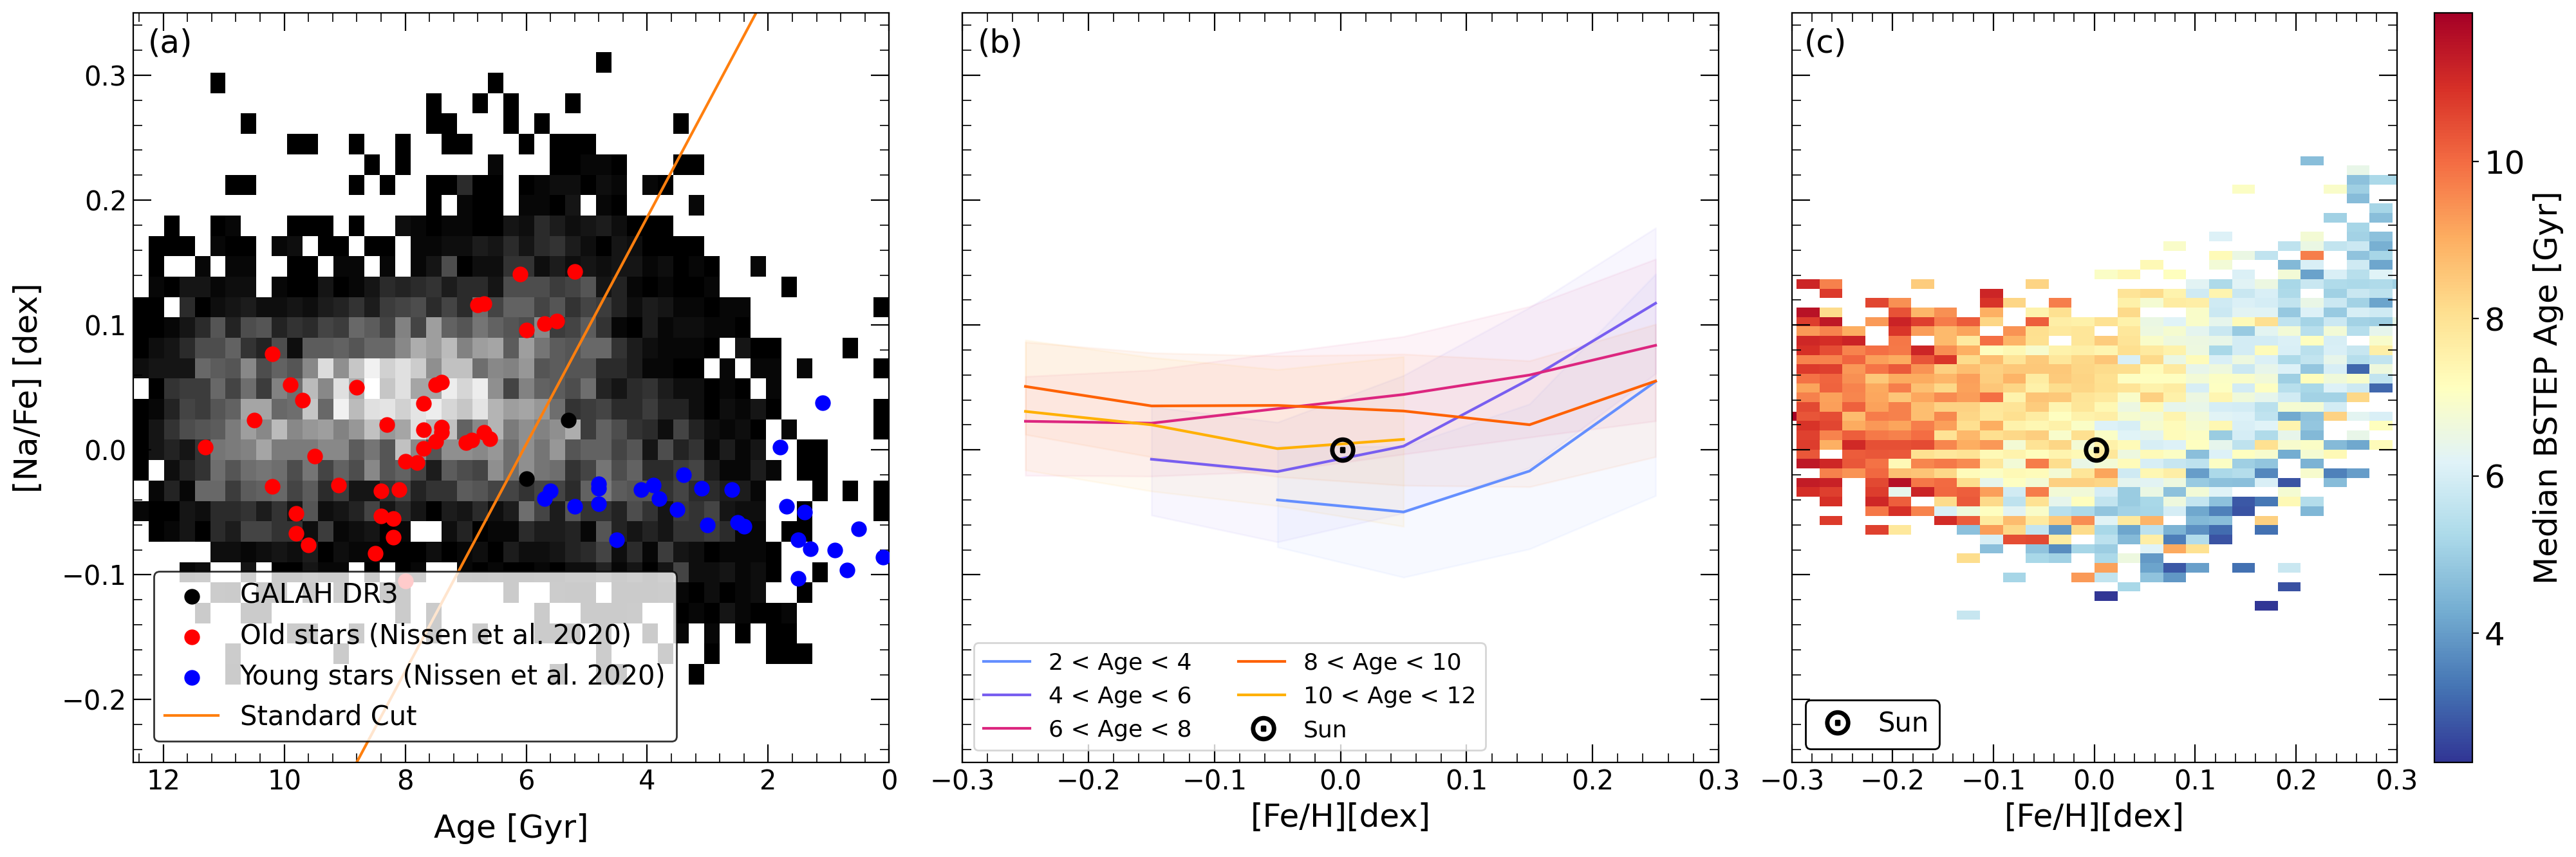

In [37]:
# Create figure and subplots with shared y-axis
fig, gs = plt.subplots(1, 3, sharey=True, figsize=(20.25,6.75))

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2, wspace=0.15)

# Annotate subplots
labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(gs):
    ax.annotate(labels[i], xy=(0.02, 0.98), xycoords='axes fraction', 
                fontsize=18, verticalalignment='top', 
                horizontalalignment='left')

# Define the line separating young and old stars
element = 'Na'
linear_formula = 0.55 - 0.5/5.5 * np.linspace(0, 12.5, 50)

# First subplot
plot_xfe_vs_age(gs[0], solar_type, each_element=element, xfe_range=[-0.4, 0.4], age_bins=np.linspace(0, 12.5, 50))
gs[0].set_xlabel('Age [Gyr]', fontsize=18, labelpad=10)
gs[0].set_ylabel('[Na/Fe] [dex]', fontsize=18, labelpad=10)
gs[0].scatter(nissen_both['Age'][neither], nissen_both['__'+element+'_Fe_'][neither], c='k', s=60, zorder=5, label='GALAH DR3')
gs[0].scatter(nissen_both['Age'][old], nissen_both['__'+element+'_Fe_'][old], c='r', s=60, zorder=5, label='Old stars (Nissen et al. 2020)')
gs[0].scatter(nissen_both['Age'][young], nissen_both['__'+element+'_Fe_'][young], c='b', s=60, zorder=5, label='Young stars (Nissen et al. 2020)')
gs[0].plot(np.linspace(0, 12.5, 50, endpoint=True), linear_formula, c='C11', label='Standard Cut')
gs[0].invert_xaxis()
# Legends
gs[0].legend(fontsize=15, frameon=True, edgecolor='black', loc='lower left',bbox_to_anchor=(0.01, 0.01), ncol=1)

# Plot your data
plot_fe_h_vs_Na_fe_in_age_bins(solar_type, gs[1])
gs[1].set_xlim(-0.3, 0.3)
gs[1].set_xlabel('[Fe/H][dex]', fontsize=18)

# Second subplot
plot_2dhist_fe_h_vs_Na_fe_colored_by_age(solar_type, gs[2])
gs[2].set_xlim(-0.3, 0.3)
gs[2].set_xlabel('[Fe/H][dex]', fontsize=18)

# add minor ticks to all subplots
for ax in gs:
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))


plt.tight_layout()
plt.savefig(latexpath+'figures/figure1.pdf', format='pdf', dpi=600, bbox_inches='tight')#age_na_fe_solar
plt.show()

# Figure: Plot age-abundance sequences

In [14]:
# Define the linear function
def linear_func(x, m, b):
    return m * x + b
# Create the subplots grid
fig, axs = plt.subplots(3, 7, figsize=(15,7.5), dpi=300, sharex=True, sharey=True)

# Make horizontal space between plots zero
fig.subplots_adjust(hspace=0.1, wspace=0.2)

colors = ['C0', 'C1', 'royalblue', 'r']

# calculate row and column indices
for i, element in enumerate(elements):
    ax_row, ax_col = i // 7, i % 7  
    ax = axs[ax_row][ax_col]

    # We only want to work with finite values for both disc popiulations
    na_thin_nonan = np.logical_and(young_sequence, np.logical_not(np.isnan(galah[element+'_fe'])))
    na_thick_nonan = np.logical_and(old_sequence, np.logical_not(np.isnan(galah[element+'_fe'])))

    # 2D histogram for GALAH DR3 disc selection
    ax.hist2d(galah['age_bstep'][na_thin_nonan], 
              galah[element+'_fe'][na_thin_nonan],
              bins=(np.linspace(0,12.5,100), np.linspace(-0.5,0.5,200)), norm=LogNorm(), cmap='Blues')
    
    ax.hist2d(galah['age_bstep'][na_thick_nonan], 
              galah[element+'_fe'][na_thick_nonan],
              bins=(np.linspace(0,12.5,100), np.linspace(-0.5,0.5,200)), norm=LogNorm(), cmap='Oranges')
    
    # Nissen data
    if '__'+element+'_Fe_' in nissen_both.colnames:
        ax.scatter(nissen_both['Age'][young], 
                   nissen_both['__'+element+'_Fe_'][young], 
                   s=15, c=colors[2])
    
        ax.scatter(nissen_both['Age'][old], 
                   nissen_both['__'+element+'_Fe_'][old], 
                   s=15, c=colors[3])
    
    # Calculate median age and abundance for stars between 5-8 Gyr
    mask_5_8 = (galah['age_bstep'][na_thick_nonan] >= 5) & (galah['age_bstep'][na_thick_nonan] <= 8)
   
    median_age = np.median(galah['age_bstep'][na_thick_nonan][mask_5_8])
    median_abundance = np.median(galah[element+'_fe'][na_thick_nonan][mask_5_8]) # .compressed() removes NaNs in masked array

     # Calculate standard deviation (or other measure of uncertainty) for both age and abundance
    age_median_error = np.median(galah['e_age_bstep'][na_thick_nonan][mask_5_8])
    abundance_error_median = np.median(galah['e_'+element+'_fe'][na_thick_nonan][mask_5_8])
    abundance_error = galah['e_'+element+'_fe'][na_thick_nonan][mask_5_8]

    # Extract data for the 5-8 Gyr range
    ages_5_8 = galah['age_bstep'][na_thick_nonan][mask_5_8]
    abundances_5_8 = galah[element+'_fe'][na_thick_nonan][mask_5_8].compressed()

    # Ensure both arrays are of the same length
    common_length = min(len(ages_5_8), len(abundances_5_8))
    ages_5_8 = ages_5_8[:common_length]
    abundances_5_8 = abundances_5_8[:common_length]

# Perform linear regression using curve_fit function from scipy.
    coefficients, covariance = curve_fit(linear_func, ages_5_8, abundances_5_8, sigma=abundance_error)

# Extract the slope and intercept
    m, b = coefficients
    
    # Calculate the standard error of the slope
    slope_std_err = np.sqrt(covariance[0, 0])
    # Plot the fitted line on the subplot
    ax.plot(ages_5_8, m*ages_5_8 + b, color='k', linestyle='-', label=f'Fitted Line for {element}') #C19
    
    # Set the fixed position for the error bars
    fixed_y_position = -0.25
    fixed_x_position = 2.0
    # Plot error bars at the lower center of each panel
    ax.errorbar(fixed_x_position, fixed_y_position, xerr=age_median_error, yerr=abundance_error_median, color='k', fmt='none', capsize=3, markersize=1, label='5-8 Gyr Stars')
   
    ax.set_xlim(0, 12)
    #invert the x axis
    ax.invert_xaxis()
    ax.set_ylim(-0.4, 0.4)

    # Set x and y axis ticks inside the plot for each element
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.set_xticks(np.arange(0, 12, 2))
    ax.set_yticks(np.arange(-0.4, 0.5, 0.2))
    
    # Add x-label only to the subplots in the bottom row
    if ax_row == 2: 
        ax.set_xlabel('Age [Gyr]', fontsize=16)
    
    # Add y-label only to the subplots in the first column
    if ax_col == 0:
        ax.set_ylabel('[X/Fe]', fontsize=16)
    
    # Add element symbol as text inside each subplot
    ax.text(0.5, 0.85, f'{element}', fontsize=18, transform=ax.transAxes)

# Create legend outside the subplots
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]

fig.legend(handles=legend_elements, labels=['young sequence', 'old sequence', 'Nissen Young Stars', 'Nissen Old Stars'], 
           bbox_to_anchor=(0.5, 0.88), loc='lower center', ncol=4, fontsize=12.5, frameon=False)

plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16, direction='in', top=True, right=True, width=1)
plt.tick_params(axis='both', which='minor', labelsize=16, direction='in', top=True, right=True, width=0.5)

#plt.savefig(latexpath+'figures/figure2.png', format='png', dpi=300, bbox_inches='tight')#solar_median_age_abundance
plt.show()

In [15]:
def linear_function(age, *coefficients):
    bias, slope = coefficients
    return(bias + slope * age)

linear_fits = dict()
linear_fit_covariances = dict()
linear_fit_sigmas = dict()

elements = ['C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','Ti2','V','Cr','Mn','Co','Ni','Cu','Zn','Y','Ba','La']
element_z = [6,8,11,12,13,14,19,20,21,22,22,24,25,27,28,29,30,39,56,57]

tabular_text = [
    [r'\begin{tabular}{ccccccc}'],
    [r'\hline \hline'],
    [r'Atomic Number & Element & Gradient $5.0-8.0\,\,\mathrm{Gyr}$  & Gradient $6.5-8.0\,\,\mathrm{Gyr}$ & Gradient $5.0-6.5\,\mathrm{Gyr}$ \\%& $\Delta$Fit \\'],
    [r'& & $\mathrm{dex\,Gyr^{-1}}$ & $\mathrm{dex\,Gyr^{-1}}$ & $\mathrm{dex\,Gyr^{-1}}$\\'],
    [r'\hline']
]

for z, element in zip(element_z,elements):
    
    element_text = str(z)+' & '+element
    
    ages_low = [5.0,6.5,5.0]
    ages_high = [8.0,8.0,6.5]

    # ages_low = [5.0]
    # ages_high = [6.5]
    
    
    for age_low, age_high in zip(ages_low, ages_high):
        
        age_selection = (
            solar_type & 
            (galah['Na_fe'] > 0.55 - 0.5/5.5 * galah['age_bstep']) & 
            (galah['age_bstep'] > age_low) & (galah['age_bstep'] <= age_high) & 
            (galah['flag_'+element+'_fe'] == 0)
        )

        # ToDo adjust dictionaries to have 3 different age keywords instead of none!
        
        linear_fits[element], linear_fit_covariances[element] = curve_fit(
            linear_function,
            13.8 - galah['age_bstep'][age_selection],
            galah[element+'_fe'][age_selection],
            p0=[0,0],
            sigma=galah['e_'+element+'_fe'][age_selection],
            absolute_sigma=True,
        )
        linear_fit_sigmas[element] = np.sqrt(np.diag(linear_fit_covariances[element]))

        slope = linear_fits[element][1]
        #print(str(slope)+',') 
        slope_sigma = linear_fit_sigmas[element][1]
        #print(str(slope_sigma)+',')  
        if slope_sigma > 10.0:
            significant_places = 0
            form = "{:.0f}"
        elif slope_sigma > 1.0:
            significant_places = 1
            form = "{:.1f}"
        elif slope_sigma > 0.10:
            significant_places = 2
            form = "{:.2f}"
        elif slope_sigma > 0.010:
            significant_places = 3
            form = "{:.3f}"
        # elif slope_sigma > 0.0010:
        else:
            significant_places = 4
            form = "{:.4f}"

        minus_placeholder = ''
        if slope >= 0.:
            minus_placeholder = '\,\,\,\,'
            
        np.savetxt(latexpath+
    'text/slope_'+str(age_low)+'_'+str(age_high)+'_'+element+'.tex', [r'$'+form.format(np.round(slope,significant_places))+' \pm '+form.format(np.round(slope_sigma,significant_places))+'\,\mathrm{dex/Gyr}$'], fmt='%s')
            
        element_text = element_text+r' & $'+minus_placeholder+form.format(np.round(slope,significant_places))+' \pm '+form.format(np.round(slope_sigma,significant_places))+'$'

    tabular_text.append([element_text+r' \\'])

tabular_text.append([r'\hline \hline'])    
tabular_text.append([r'\end{tabular}'])    
np.savetxt(latexpath+'text/tabular_slopes.tex',np.array(tabular_text),fmt='%s')

# Comparison with previous thin and thick disc separation (i.e., Recio-Blanco et al. (2014) and Hayden et al. (2015))
- Replicate the Recio-Blanco or Hayden selection in the [Fe/H] vs [alpha/Fe] plane (Figure Xa) including the Recio-Blanco cut would be \\
- and then show where these stars are in the Age-[Na/Fe] plane (Figure Xb). \\
- We try to make the point that our separation is actually cleaner. \\
- Quantify, how many stars of thin disk are in young sequence (positive positive) versus thin disk stars in old sequence (positive false) and vice-versa.\\
- then put these numbers into the abstract!

In [16]:
def plot_xfe_vs_age(ax, selection,each_element, xfe_range=[-0.5,1.5], age_bins = np.linspace(0,12.5,50)):

    age = galah['age_bstep'][selection]
    xfe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        age,
        xfe,
        bins = (
            age_bins,
            np.linspace(xfe_range[0],xfe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )


def plot_mgfe_vs_feh(ax, selection,each_element, mgfe_range=[-0.2,0.5], feh_bins = np.linspace(-2.5,0.5,50)):

    feh = galah['fe_h'][selection]
    mgfe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        feh,
        mgfe,
        bins = (
            feh_bins,
            np.linspace(mgfe_range[0],mgfe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )



def plot_alphafe_vs_feh(ax, selection,each_element, alphafe_range=[-0.2,0.5], feh_bins = np.linspace(-2.5,0.5,50)):

    feh = galah['fe_h'][selection]
    alphafe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        feh,
        alphafe,
        bins = (
            feh_bins,
            np.linspace(alphafe_range[0],alphafe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )

In [17]:
def plot_xfe_vs_age(ax, selection,each_element, xfe_range=[-0.5,1.5], age_bins = np.linspace(0,12.5,50)):

    age = galah['age_bstep'][selection]
    xfe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        age,
        xfe,
        bins = (
            age_bins,
            np.linspace(xfe_range[0],xfe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )


def plot_mgfe_vs_feh(ax, selection,each_element, mgfe_range=[-0.2,0.5], feh_bins = np.linspace(-2.5,0.5,50)):

    feh = galah['fe_h'][selection]
    mgfe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        feh,
        mgfe,
        bins = (
            feh_bins,
            np.linspace(mgfe_range[0],mgfe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )



def plot_alphafe_vs_feh(ax, selection,each_element, alphafe_range=[-0.2,0.5], feh_bins = np.linspace(-2.5,0.5,50)):

    feh = galah['fe_h'][selection]
    alphafe = galah[each_element+'_fe'][selection]

    ax.hist2d(
        feh,
        alphafe,
        bins = (
            feh_bins,
            np.linspace(alphafe_range[0],alphafe_range[1],50)
        ),
        cmin=1,cmap='Greys_r',label='GALAH DR3'
    )

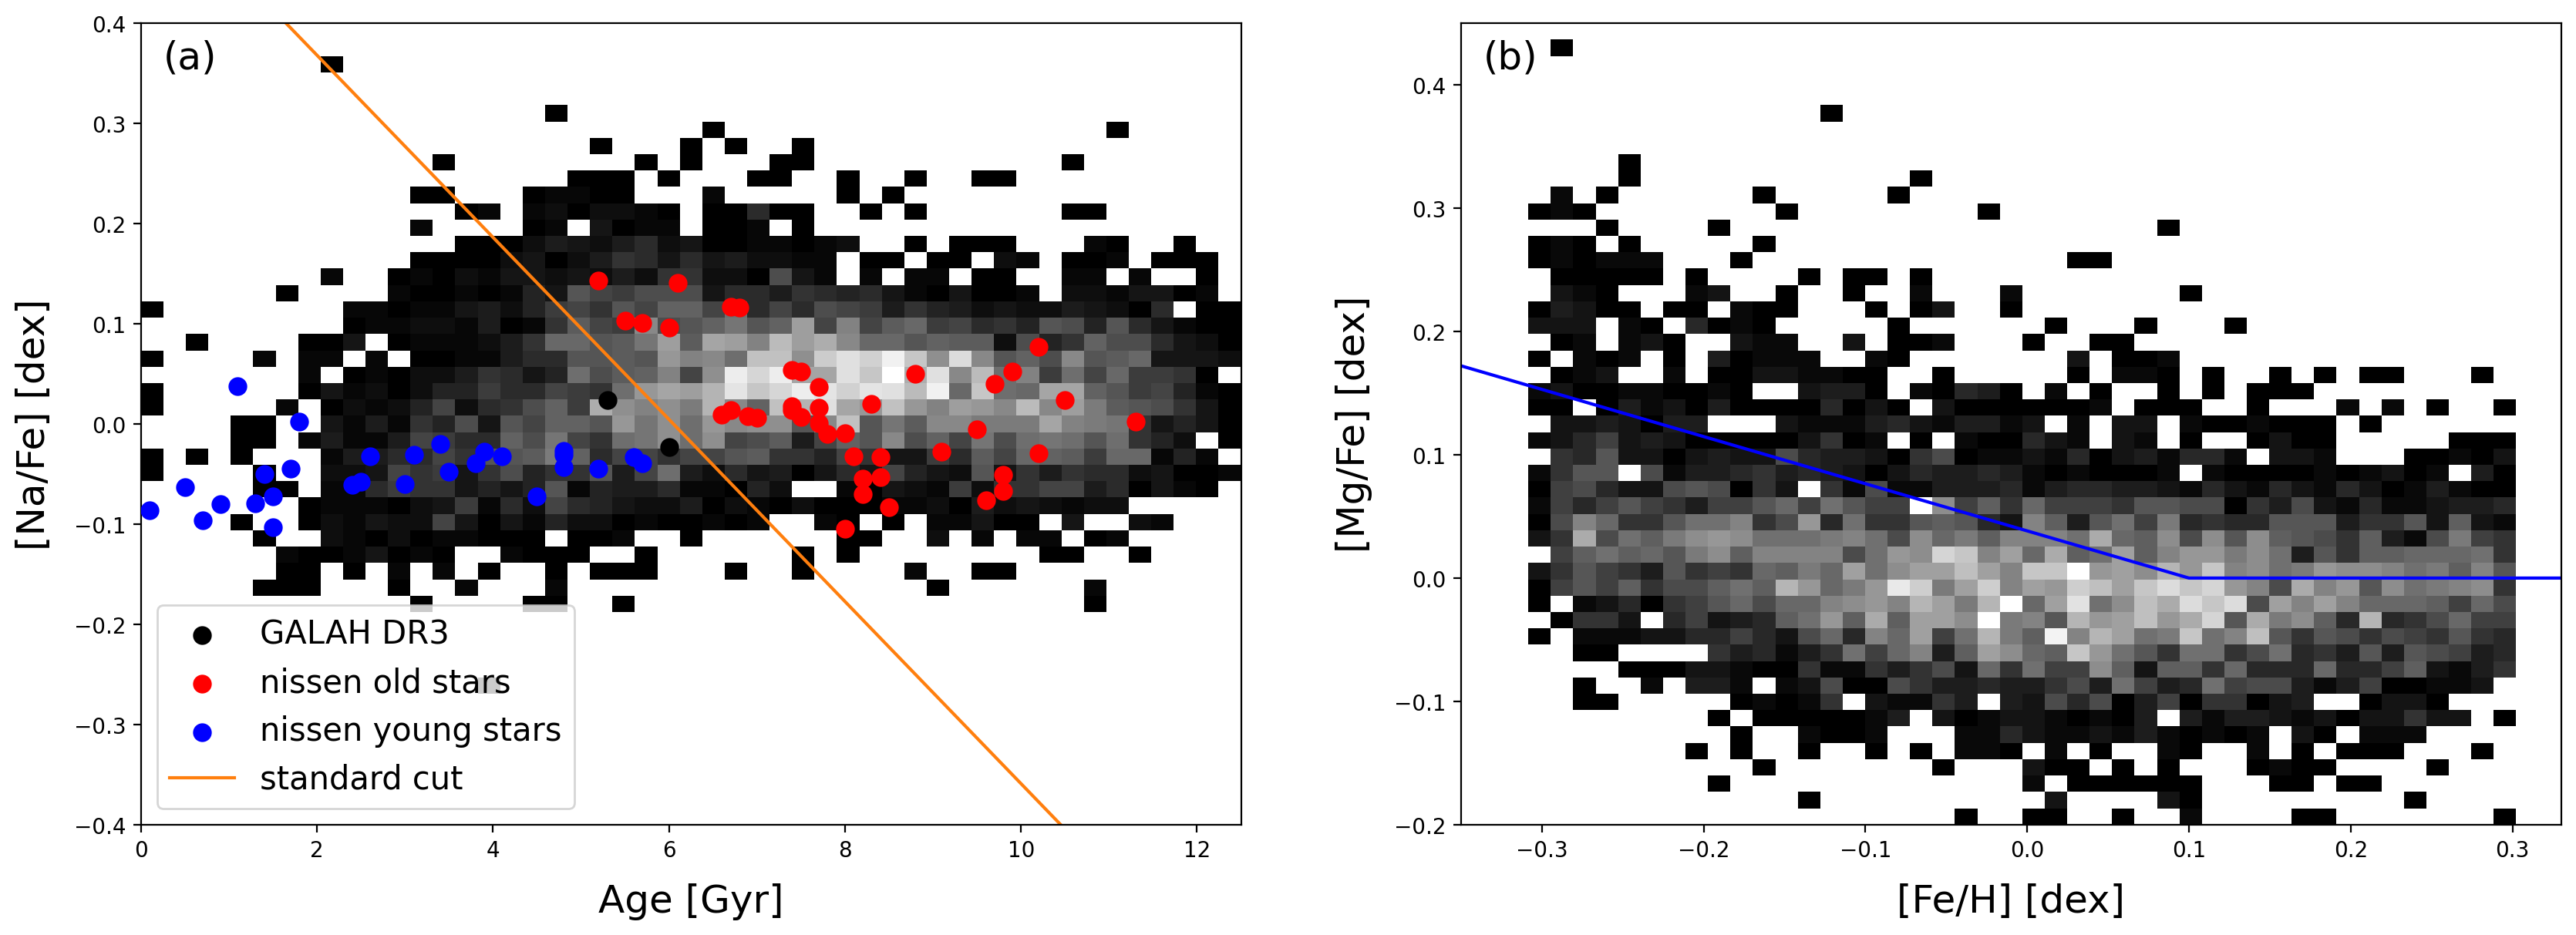

In [18]:
# Create figure and subplots with shared y-axis
fig, gs = plt.subplots(1, 2, figsize=(20.25,6.75))

# Annotate subplots
labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(gs):
    ax.annotate(labels[i], xy=(0.02, 0.98), xycoords='axes fraction', 
                fontsize=18, verticalalignment='top', 
                horizontalalignment='left')

# Define the line separating young and old stars
element = 'Na'
linear_formula = 0.55 - 0.5/5.5 * np.linspace(0, 12.5, 50)

# First subplot
plot_xfe_vs_age(gs[0], solar_type, each_element=element, xfe_range=[-0.4, 0.4], age_bins=np.linspace(0, 12.5, 50))
gs[0].set_xlabel('Age [Gyr]', fontsize=18, labelpad=10)
gs[0].set_ylabel('[Na/Fe] [dex]', fontsize=18, labelpad=10)
gs[0].scatter(nissen_both['Age'][neither], nissen_both['__'+element+'_Fe_'][neither], c='k', s=60, zorder=5, label='GALAH DR3')
gs[0].scatter(nissen_both['Age'][old], nissen_both['__'+element+'_Fe_'][old], c='r', s=60, zorder=5, label='nissen old stars')
gs[0].scatter(nissen_both['Age'][young], nissen_both['__'+element+'_Fe_'][young], c='b', s=60, zorder=5, label='nissen young stars')
gs[0].plot(np.linspace(0, 12.5, 50, endpoint=True), linear_formula, c='C11', label='standard cut')
gs[0].legend(loc='lower left', fontsize=15)
gs[0].xaxis_inverted()

element2 = 'Mg'
# Second subplot
plot_mgfe_vs_feh(gs[1], solar_type, each_element=element2, mgfe_range=[-0.2, 0.45], feh_bins = np.linspace(-0.35,0.33))
gs[1].set_xlabel('[Fe/H] [dex]', fontsize=18, labelpad=10)
gs[1].set_ylabel('[Mg/Fe] [dex]', fontsize=18, labelpad=10)
mgfe_values = [0.22, 0.22, 0.0, 0.0] 
feh_values = [-1.0, -0.475, 0.1, 0.45]
gs[1].plot(feh_values,mgfe_values,c='blue',label='Hayden et al. (2015)')

# Defining a fucntion to select data

In [19]:
above_hayden_line = (
    solar_type & 
    (
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

above_hayden_old = (
    above_hayden_line & 
    old_sequence
)
above_hayden_young = (
    above_hayden_line & 
    young_sequence
)

below_hayden_line = (
    solar_type & 
    ~(
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

below_hayden_old = (
    below_hayden_line & 
    old_sequence
)

below_hayden_young = (
    below_hayden_line & 
    young_sequence
)

print('above_hayden_old', len(galah['fe_h'][above_hayden_old]), np.round(100 * len(galah['fe_h'][above_hayden_old])/len(galah['fe_h'][solar_type]),2))
print('above_hayden_young',len(galah['fe_h'][above_hayden_young]), np.round(100 * len(galah['fe_h'][above_hayden_young])/len(galah['fe_h'][solar_type]),2))
print('below_hayden_old',len(galah['fe_h'][below_hayden_old]), np.round(100 * len(galah['fe_h'][below_hayden_old])/len(galah['fe_h'][solar_type]),2))
print('below_hayden_young',len(galah['fe_h'][below_hayden_young]), np.round(100 * len(galah['fe_h'][below_hayden_young])/len(galah['fe_h'][solar_type]),2))

#f, gs = plt.subplots(1,2)
f,gs = plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(wspace=0.8, hspace=0.8)


ax = gs[0]
ax.scatter(
    galah['fe_h'][solar_type & ~above_hayden_line],
    galah['Mg_fe'][solar_type & ~above_hayden_line],
    s = 1
)
ax.scatter(
    galah['fe_h'][solar_type & above_hayden_line],
    galah['Mg_fe'][solar_type & above_hayden_line],
    s = 1
)
#add labels
ax.set_xlabel('[Fe/H] [dex]', fontsize=18)
ax.set_ylabel('[Mg/Fe] [dex]', fontsize=18)

ax = gs[1]
ax.scatter(
    galah['age_bstep'][solar_type & ~above_hayden_line],
    galah['Na_fe'][solar_type & ~above_hayden_line],
    s = 1,
    label='Thin disc (young seq.)'
)
ax.scatter(
    galah['age_bstep'][solar_type & above_hayden_line],
    galah['Na_fe'][solar_type & above_hayden_line],
    s = 1,
    label='Thick disc (old seq.)'
)
#add labels
ax.set_xlabel('Age [Gyr]', fontsize=15)
ax.set_ylabel('[Na/Fe] [dex]', fontsize=15)  
gs[1].plot(np.linspace(0, 12.5, 50, endpoint=True), linear_formula, c='C11', label='standard cut')
gs[1].set_ylim(-0.4, 0.4)
gs[0].set_ylim(-0.4, 0.4)
# plt.savefig(latexpath+'figures/hayden.png', format='png', dpi=600, bbox_inches='tight')
#add minor ticks to all subplots
# Create legend patches
thick_disc_patch = mpatches.Patch(color='orange', label='High [Mg/Fe] (Old seq.)')
thin_disc_patch = mpatches.Patch(color='#0072B2', label='Low [Mg/Fe] (Young seq.)')
standard_cut_patch = mpatches.Patch(color='C11', label='standard cut')

# Add legend to the second subplot
ax.legend(handles=[thick_disc_patch,thin_disc_patch, standard_cut_patch], loc=0, fontsize=10, frameon=True, edgecolor='black')

# Add minor ticks to all subplots
for ax in gs:
    ax.minorticks_on()
plt.tight_layout()
#add legend labels
plt.savefig(latexpath+'figures/Hayden_cut.pdf', format='pdf', dpi=600, bbox_inches='tight')#hayden
plt.show()

above_hayden_old 1328 21.3
above_hayden_young 248 3.98
below_hayden_old 3415 54.78
below_hayden_young 1243 19.94


In [20]:
matrix = np.array([
    [100*len(galah['fe_h'][above_hayden_old])/len(galah['fe_h'][solar_type]),100*len(galah['fe_h'][above_hayden_young])/len(galah['fe_h'][solar_type])],
    [100*len(galah['fe_h'][below_hayden_old])/len(galah['fe_h'][solar_type]),100*len(galah['fe_h'][below_hayden_young])/len(galah['fe_h'][solar_type])]
])
# Set figure size
plt.figure(figsize=(3.6, 3.6)) 

s = plt.imshow(matrix)
plt.text(0,0,str(int(np.round(100*len(galah['fe_h'][above_hayden_old])/len(galah['fe_h'][solar_type]),0)))+'%',color='w',va='center',ha='center',fontsize=15)
plt.text(1,0,str(int(np.round(100*len(galah['fe_h'][above_hayden_young])/len(galah['fe_h'][solar_type]),0)))+'%',color='w',va='center',ha='center',fontsize=15)
plt.text(0,1,str(int(np.round(100*len(galah['fe_h'][below_hayden_old])/len(galah['fe_h'][solar_type]),0)))+'%',color='k',va='center',ha='center',fontsize=15)
plt.text(1,1,str(int(np.round(100*len(galah['fe_h'][below_hayden_young])/len(galah['fe_h'][solar_type]),0)))+'%',color='w',va='center',ha='center',fontsize=15)
plt.xticks([0,1],['High [Mg/Fe]','Low [Mg/Fe]'],fontsize=10)
plt.yticks([0,1],['High [Na/Fe]','Low [Na/Fe]'],rotation=90,va='center',fontsize=10)
plt.xticks([0,1],['Young Seq.\n(Hayden et al. 2017)','Old Seq. \n(Hayden et al. 2017)'],fontsize=10)
plt.yticks([0,1],['Young Seq. \n(This Work)','Old Seq. \n(This Work)'],rotation=90,va='center',fontsize=10)
plt.tight_layout()
plt.savefig(latexpath+'figures/confuxion_matrix.pdf',dpi=200)#confusion_matrix

## Figures Based on Reviewers Suggestion

### Figure 1. [Fe/H] - Age diagram

In [21]:
# Define the linear function
def linear_func(x, m, b):
    return m * x + b

# Create the subplots grid
fig, axs = plt.subplots(1, 1, figsize=(7, 7), dpi=300, sharex=True, sharey=True)

# Make horizontal space between plots zero
fig.subplots_adjust(hspace=0.1, wspace=0.2)

colors = ['C0', 'C1', 'royalblue', 'r']

# Access the single axis in the 1x1 grid
ax = axs

# We only want to work with finite values for both disc populations
na_thin_nonan = np.logical_and(young_sequence, np.logical_not(np.isnan(galah['fe_h'])))
na_thick_nonan = np.logical_and(old_sequence, np.logical_not(np.isnan(galah['fe_h'])))

# 2D histogram for GALAH DR3 disc selection
ax.hist2d(galah['age_bstep'][na_thin_nonan], 
          galah['fe_h'][na_thin_nonan],
          bins=(np.linspace(0,12.5,100), np.linspace(-1.5, 0.5, 200)), norm=LogNorm(), cmap='Blues')

ax.hist2d(galah['age_bstep'][na_thick_nonan], 
          galah['fe_h'][na_thick_nonan],
          bins=(np.linspace(0,12.5,100), np.linspace(-1.5, 0.5, 200)), norm=LogNorm(), cmap='Oranges')

#

# Nissen data
ax.scatter(nissen_both['Age'][young], 
           nissen_both['__Fe_H_'][young], 
           s=30, c=colors[2], edgecolors='k', linewidths=1)

ax.scatter(nissen_both['Age'][old], 
           nissen_both['__Fe_H_'][old], 
           s=30, c=colors[3], edgecolors='k')

# Calculate median age and abundance for stars between 5-8 Gyr
mask_5_8 = (galah['age_bstep'][na_thick_nonan] >= 5) & (galah['age_bstep'][na_thick_nonan] <= 8)

median_age = np.median(galah['age_bstep'][na_thick_nonan][mask_5_8])
median_abundance = np.median(galah['fe_h'][na_thick_nonan][mask_5_8])

# Calculate standard deviation (or other measure of uncertainty) for both age and abundance
age_median_error = np.median(galah['e_age_bstep'][na_thick_nonan][mask_5_8])
abundance_error_median = np.median(galah['e_fe_h'][na_thick_nonan][mask_5_8])
abundance_error = galah['e_fe_h'][na_thick_nonan][mask_5_8]

# Extract data for the 5-8 Gyr range
ages_5_8 = galah['age_bstep'][na_thick_nonan][mask_5_8]
abundances_5_8 = galah['fe_h'][na_thick_nonan][mask_5_8].compressed()

# Ensure both arrays are of the same length
common_length = min(len(ages_5_8), len(abundances_5_8))
ages_5_8 = ages_5_8[:common_length]
abundances_5_8 = abundances_5_8[:common_length]

# Perform linear regression using curve_fit function from scipy.
coefficients, covariance = curve_fit(linear_func, ages_5_8, abundances_5_8, sigma=abundance_error)

# Extract the slope and intercept
m, b = coefficients

# Calculate the standard error of the slope
slope_std_err = np.sqrt(covariance[0, 0])
# Plot the fitted line on the subplot
#ax.plot(ages_5_8, m * ages_5_8 + b, color='k', linestyle='-', label='Fitted Line for [Fe/H]')

# Plot error bars at the lower center of each panel
ax.errorbar(fixed_x_position, fixed_y_position, xerr=age_median_error, yerr=abundance_error_median, color='k', fmt='none', capsize=3, markersize=1, label='5-8 Gyr Stars')

ax.set_xlim(0, 12)
ax.invert_xaxis()
ax.set_ylim(-0.5, 0.5)

# Set x and y axis ticks inside the plot for each element
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xticks(np.arange(0, 12, 2))
ax.set_yticks(np.arange(-0.4, 0.6, 0.4))

ax.set_xlabel('Age [Gyr]', fontsize=16)
ax.set_ylabel('[Fe/H]', fontsize=16)

# Create legend outside the subplots
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]

fig.legend(handles=legend_elements, labels=['young sequence', 'old sequence', 'Nissen Young Stars', 'Nissen Old Stars'], 
           bbox_to_anchor=(0.5, 0.88), loc='lower center', ncol=4, fontsize=12.5, frameon=False)

plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16, direction='in', top=True, right=True, width=1)
plt.tick_params(axis='both', which='minor', labelsize=16, direction='in', top=True, right=True, width=0.5)

plt.savefig(latexpath+'figures/figure1.pdf', format='png', dpi=300, bbox_inches='tight') # suggested [Fe/]-age abundance by reviewer
plt.show()


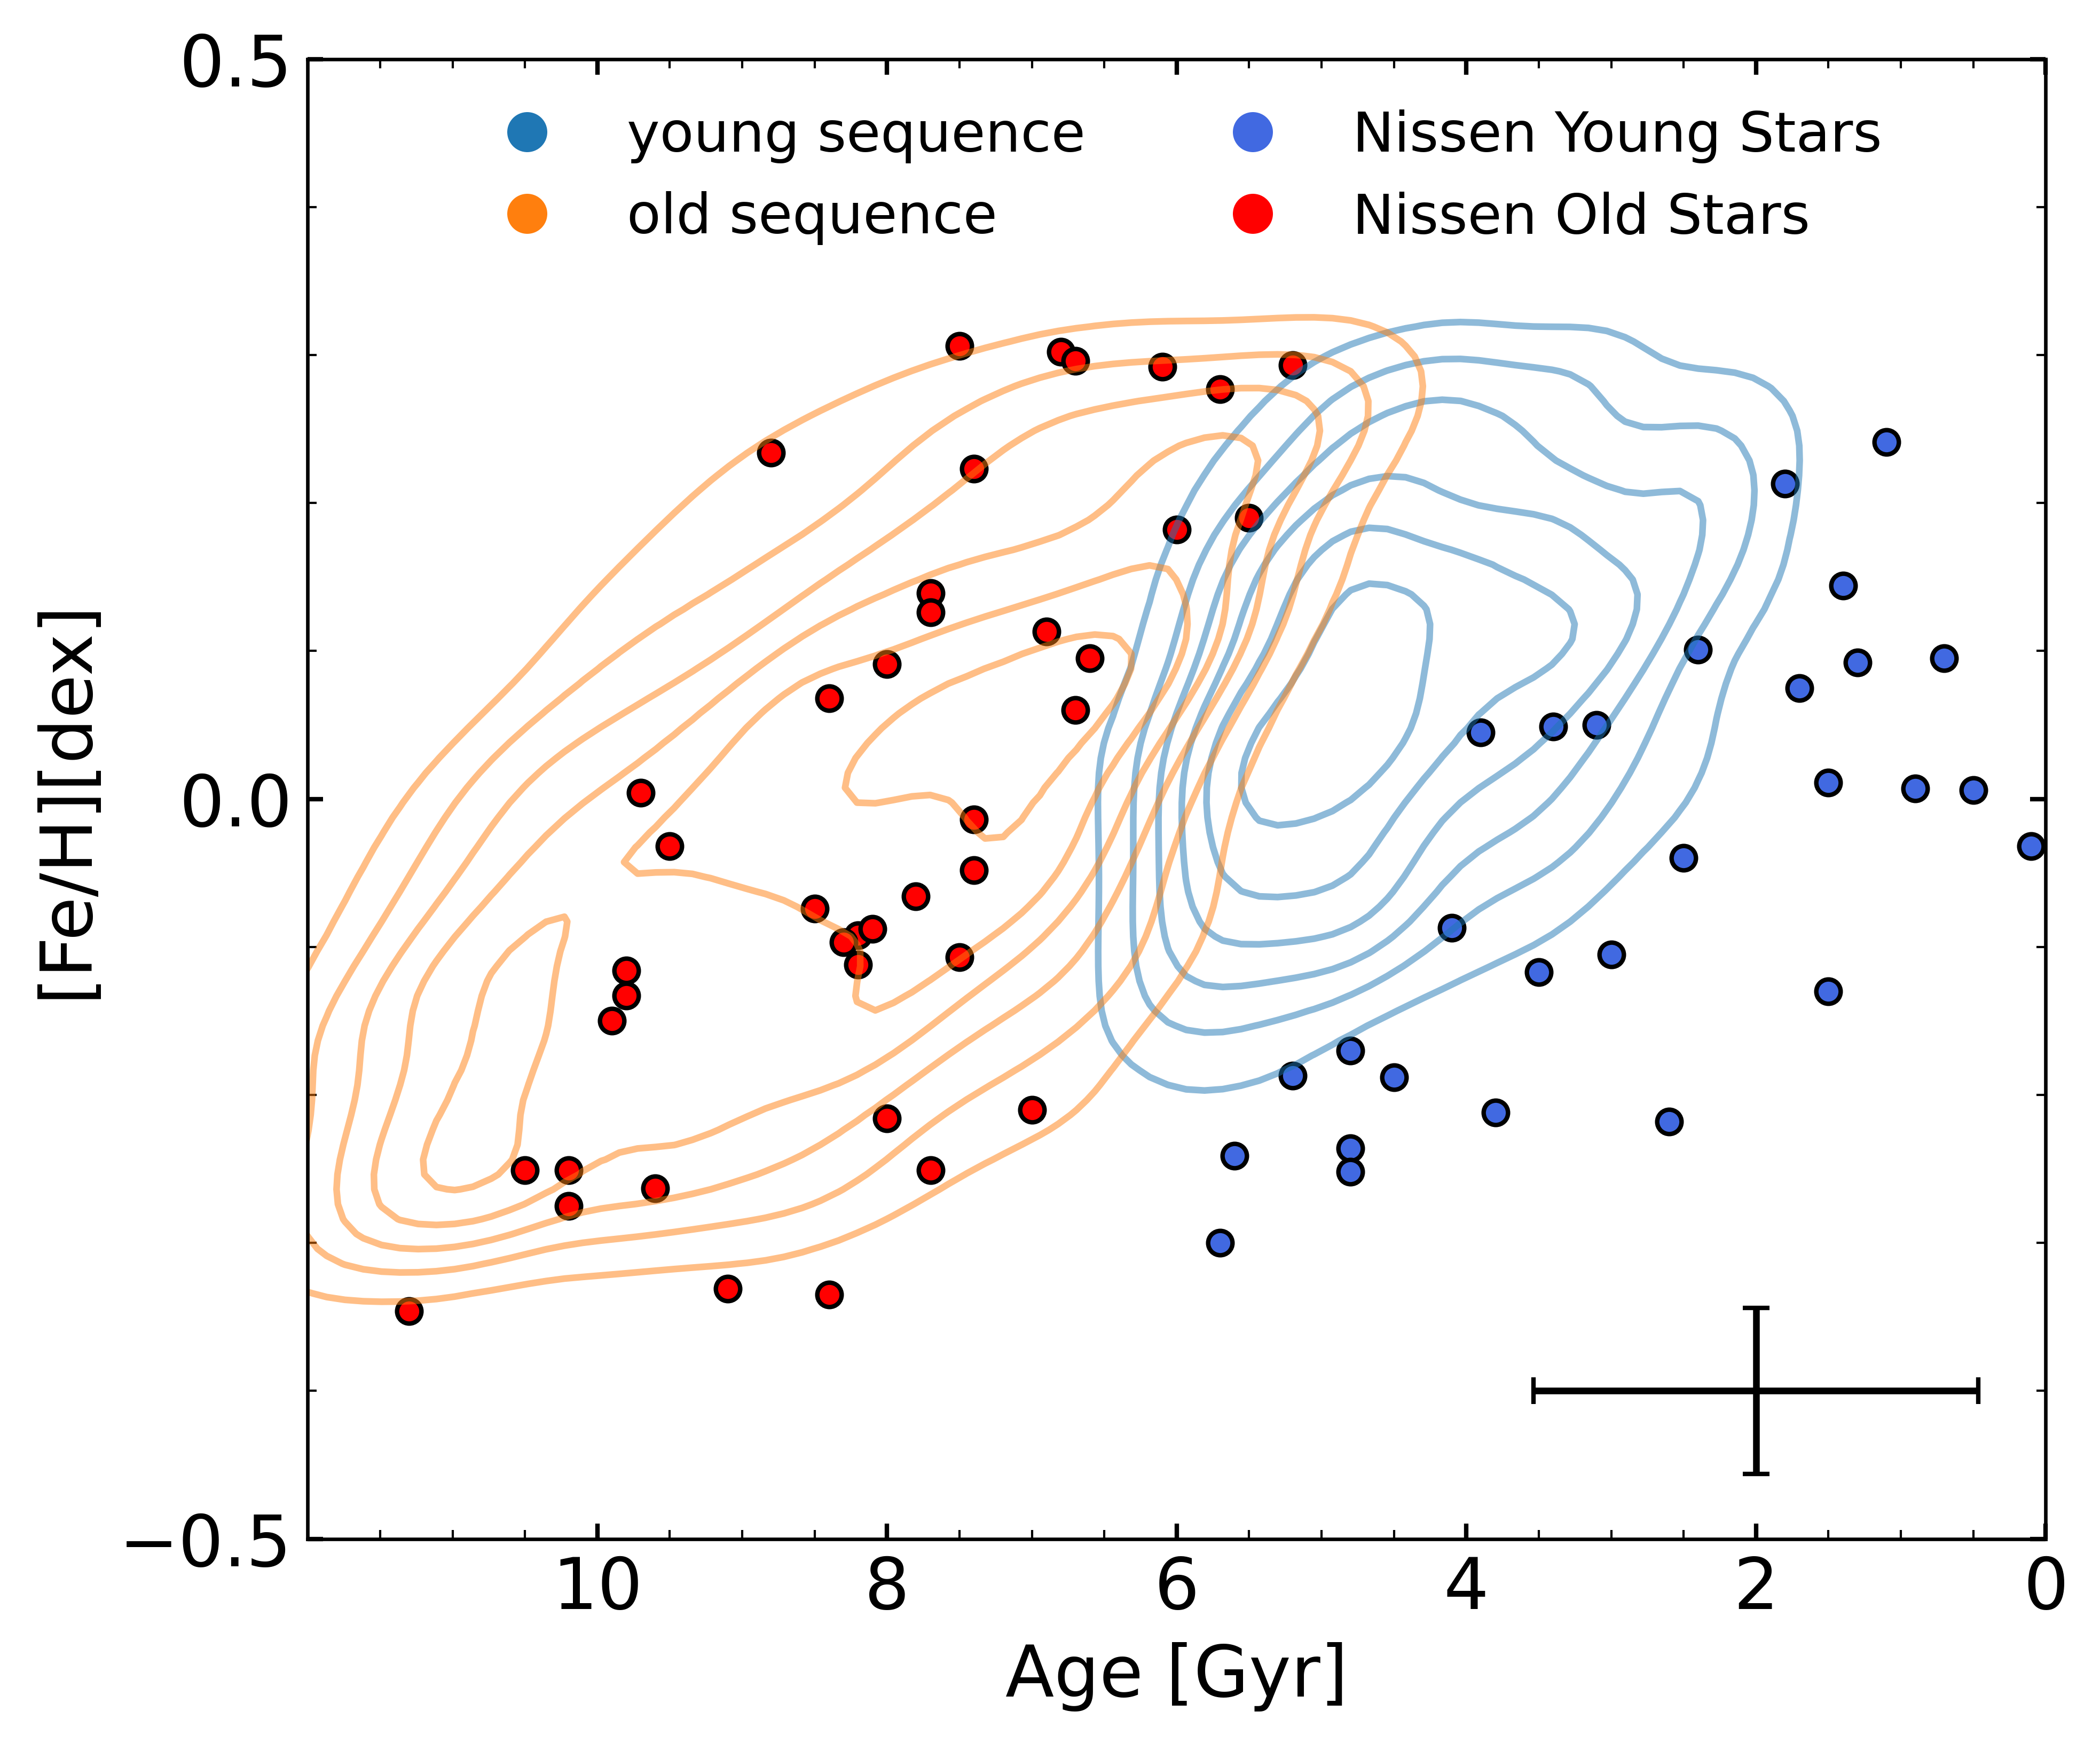

In [22]:
# Define the linear function
def linear_func(x, m, b):
    return m * x + b

# Create the subplots grid
fig, axs = plt.subplots(1, 1, figsize=(7, 6), dpi=300, sharex=True, sharey=True)

# Make horizontal space between plots zero
fig.subplots_adjust(hspace=0.1, wspace=0.2)

colors = ['C0', 'C1', 'royalblue', 'r']

# Access the single axis in the 1x1 grid
ax = axs

# We only want to work with finite values for both disc populations
na_thin_nonan = np.logical_and(young_sequence, np.logical_not(np.isnan(galah['fe_h'])))
na_thick_nonan = np.logical_and(old_sequence, np.logical_not(np.isnan(galah['fe_h'])))

# Estimate kernel density for thin and thick disk stars
kde_thin = gaussian_kde(np.vstack([galah['age_bstep'][na_thin_nonan], galah['fe_h'][na_thin_nonan]]))
kde_thick = gaussian_kde(np.vstack([galah['age_bstep'][na_thick_nonan], galah['fe_h'][na_thick_nonan]]))

# Create meshgrid for contour plot
x_grid, y_grid = np.meshgrid(np.linspace(0, 12.5, 100), np.linspace(-1.5, 0.5, 200))

# Evaluate kernel density on meshgrid
z_thin = kde_thin(np.vstack([x_grid.flatten(), y_grid.flatten()]))
z_thick = kde_thick(np.vstack([x_grid.flatten(), y_grid.flatten()]))

# Reshape z values for contour plot
z_thin = z_thin.reshape(x_grid.shape)
z_thick = z_thick.reshape(x_grid.shape)

# Plot contour density for thin and thick disk stars
ax.contour(x_grid, y_grid, z_thin, colors=colors[0], alpha=0.5)
ax.contour(x_grid, y_grid, z_thick, colors=colors[1], alpha=0.5)

# Nissen data
ax.scatter(nissen_both['Age'][young], 
           nissen_both['__Fe_H_'][young], 
           s=30, c=colors[2], edgecolors='k', linewidths=1)

ax.scatter(nissen_both['Age'][old], 
           nissen_both['__Fe_H_'][old], 
           s=30, c=colors[3], edgecolors='k')

# Calculate median age and abundance for stars between 5-8 Gyr
mask_5_8 = (galah['age_bstep'][na_thick_nonan] >= 5) & (galah['age_bstep'][na_thick_nonan] <= 8)

median_age = np.median(galah['age_bstep'][na_thick_nonan][mask_5_8])
median_abundance = np.median(galah['fe_h'][na_thick_nonan][mask_5_8])

# Calculate standard deviation (or other measure of uncertainty) for both age and abundance
age_median_error = np.median(galah['e_age_bstep'][na_thick_nonan][mask_5_8])
abundance_error_median = np.median(galah['e_fe_h'][na_thick_nonan][mask_5_8])
abundance_error = galah['e_fe_h'][na_thick_nonan][mask_5_8]

# Extract data for the 5-8 Gyr range
ages_5_8 = galah['age_bstep'][na_thick_nonan][mask_5_8]
abundances_5_8 = galah['fe_h'][na_thick_nonan][mask_5_8].compressed()

# Ensure both arrays are of the same length
common_length = min(len(ages_5_8), len(abundances_5_8))
ages_5_8 = ages_5_8[:common_length]
abundances_5_8 = abundances_5_8[:common_length]

# Perform linear regression using curve_fit function from scipy.
coefficients, covariance = curve_fit(linear_func, ages_5_8, abundances_5_8, sigma=abundance_error)

# Extract the slope and intercept
m, b = coefficients

# Calculate the standard error of the slope
slope_std_err = np.sqrt(covariance[0, 0])

# Plot error bars at the lower center of each panel
fixed_x_position = 2.0
fixed_y_position = -0.4
ax.errorbar(fixed_x_position, fixed_y_position, xerr=age_median_error, yerr=abundance_error_median, color='k', fmt='none', capsize=3, markersize=1, label='5-8 Gyr Stars')
#fix error bars at the lower bottom of the plot


ax.set_xlim(0, 12)
ax.invert_xaxis()
ax.set_ylim(-0.5, 0.5)

# Set x and y axis ticks inside the plot for each element
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xticks(np.arange(0, 12, 2))
ax.set_yticks(np.arange(-0.5, 0.6, 0.5))

ax.set_xlabel('Age [Gyr]', fontsize=16)
ax.set_ylabel('[Fe/H][dex]', fontsize=16)
# Create legend outside the subplots
#legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]

# # Custom legend elements (if needed)
# legend_elements = [
#     mlines.Line2D([], [], color='royalblue', label='young sequence'),
#     mlines.Line2D([], [], color='orange', label='old sequence'),
#     mlines.Line2D([], [], color='blue', label='Nissen Young Stars'),
#     mlines.Line2D([], [], color='red', label='Nissen Old Stars'), 
# ]

# # Add legend inside the plot
# ax.legend(handles=legend_elements, loc='lower center', frameon=False)


legend_elements = [Line2D([], [], marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]

ax.legend(handles=legend_elements, labels=['young sequence', 'old sequence', 'Nissen Young Stars', 'Nissen Old Stars'], loc='upper center', fontsize=12.5, ncol=2, frameon=False)

plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16, direction='in', top=True, right=True, width=1)
plt.tick_params(axis='both', which='minor', labelsize=16, direction='in', top=True, right=True, width=0.5)
#plt.savefig(latexpath+'figures/age_feh_contour.pdf', format='pdf', dpi=300, bbox_inches='tight')#solar_median_age_abundance
plt.show()


0.0 0.0
1.0036032458188635 0.5154919367383516


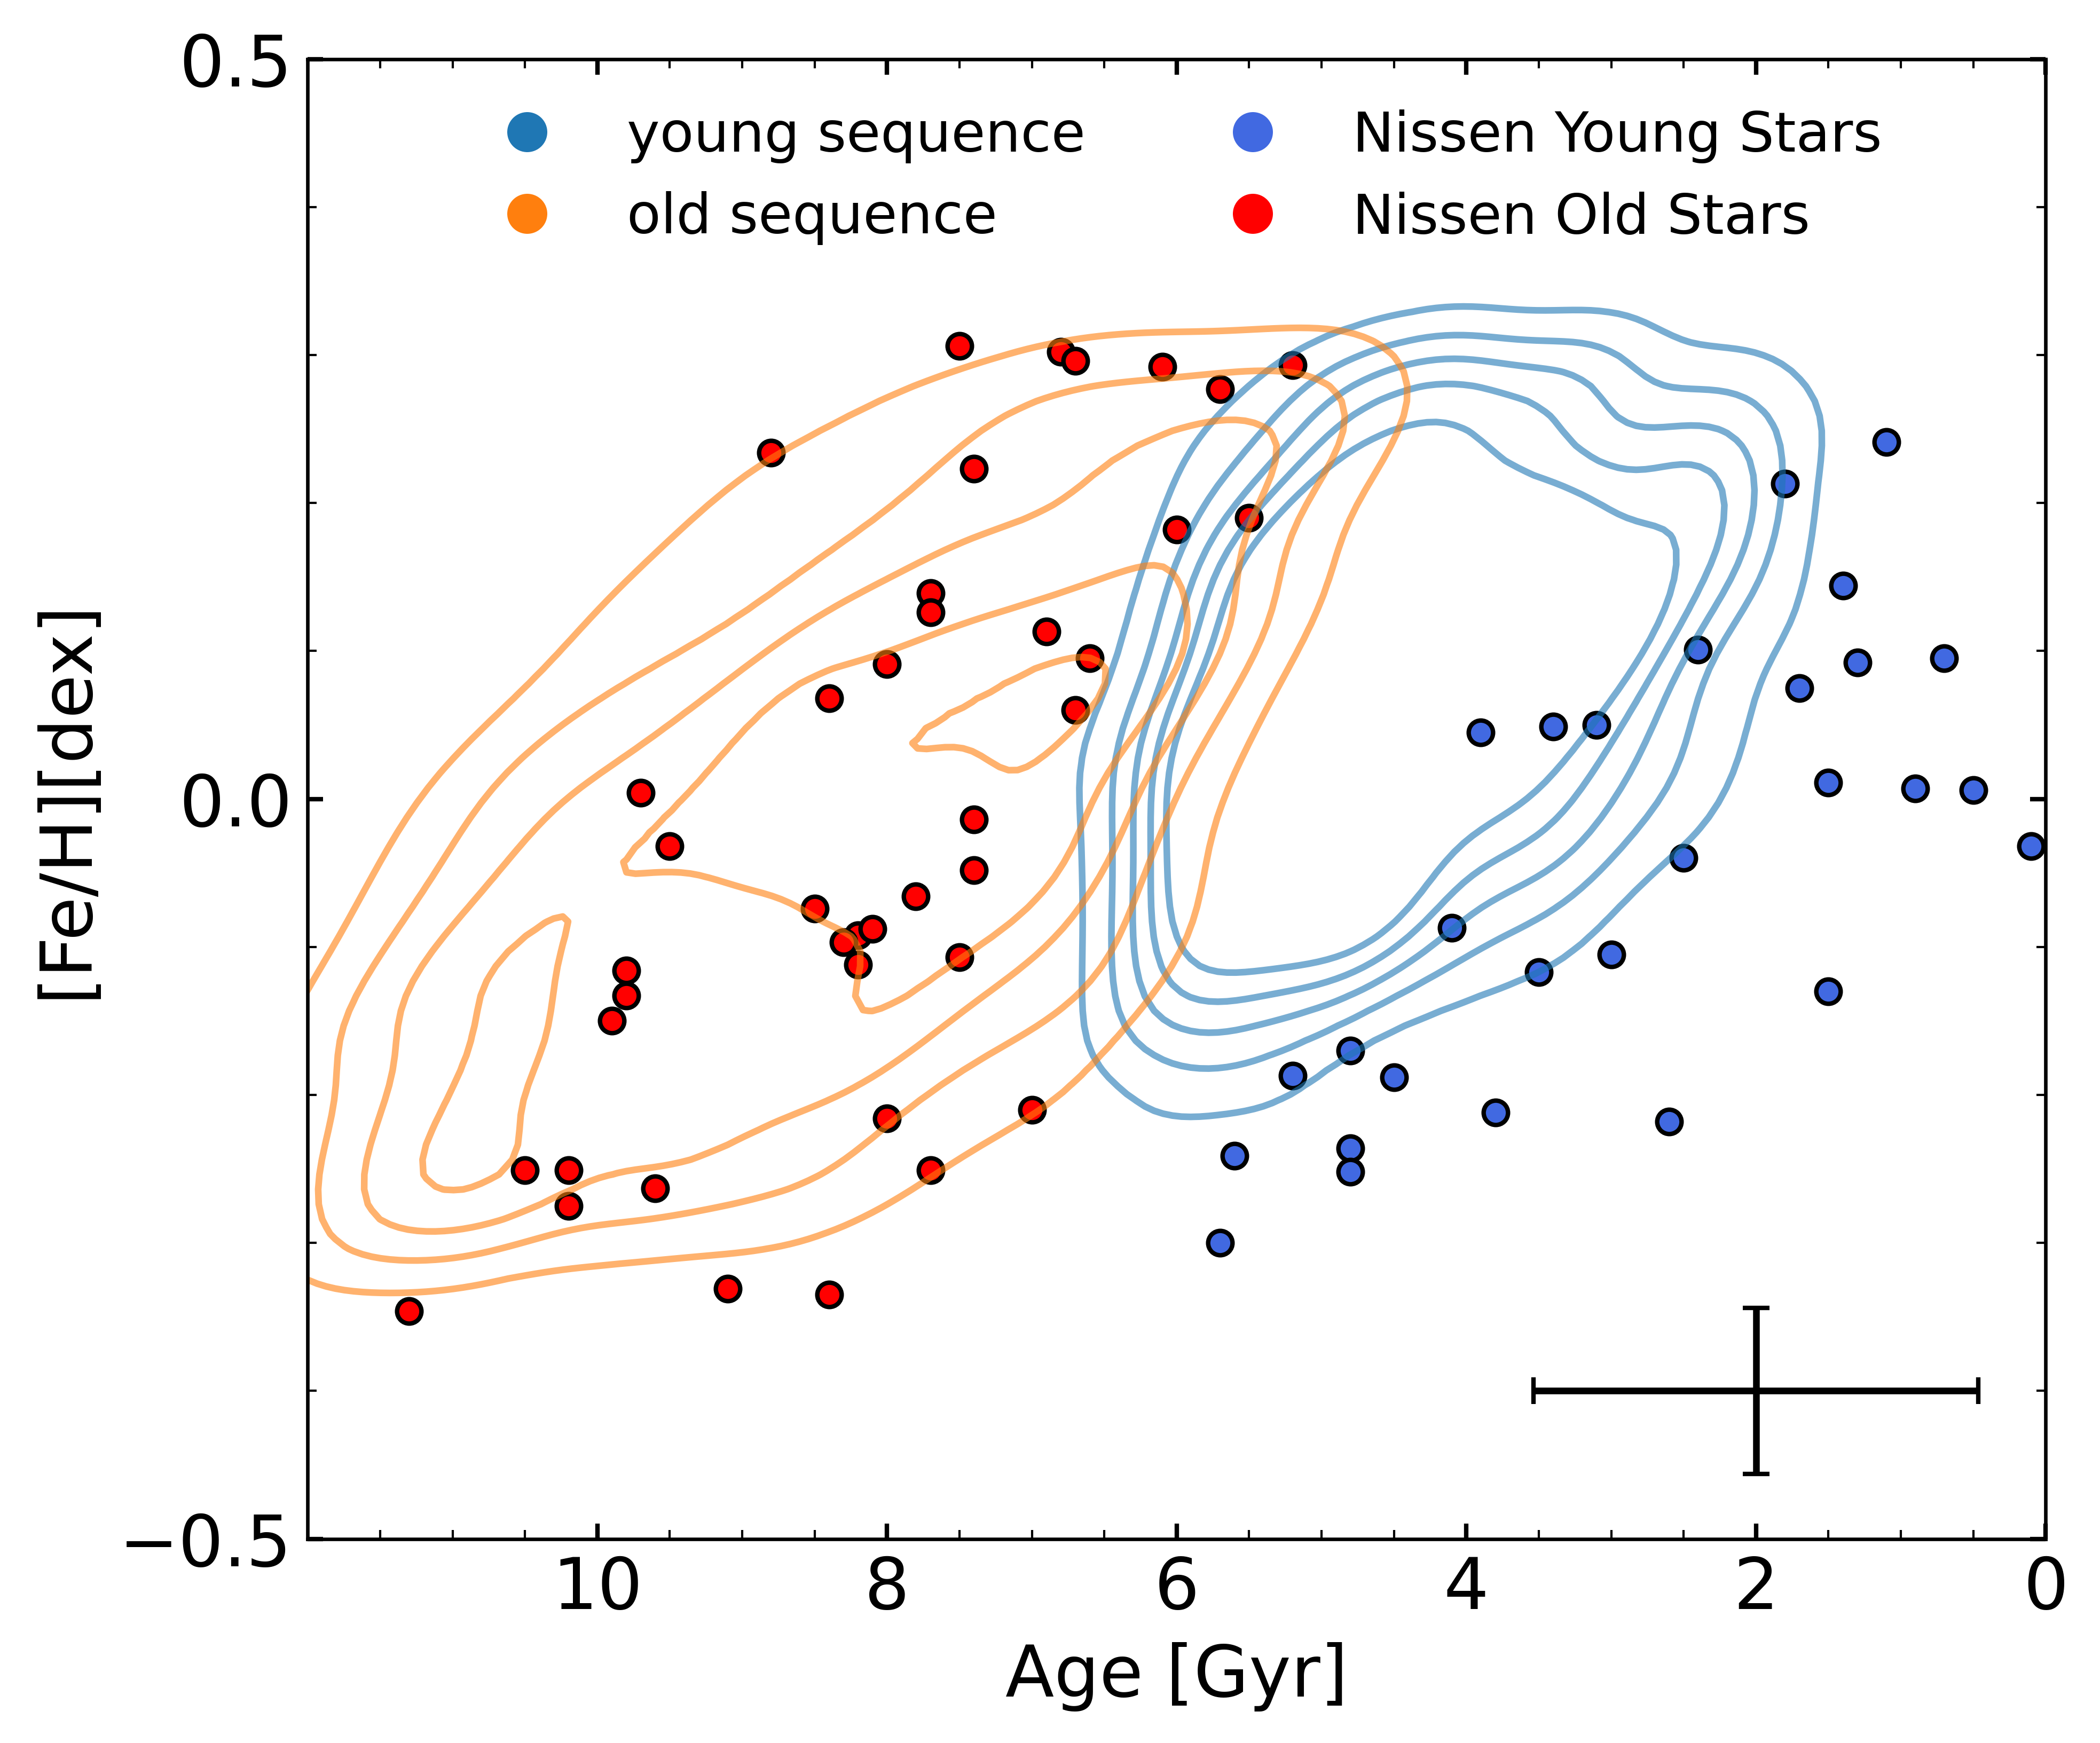

In [23]:
# Define the linear function
def linear_func(x, m, b):
    return m * x + b

# Create the subplots grid
fig, axs = plt.subplots(1, 1, figsize=(7, 6), dpi=300, sharex=True, sharey=True)

# Make horizontal space between plots zero
fig.subplots_adjust(hspace=0.1, wspace=0.2)

colors = ['C0', 'C1', 'royalblue', 'r']

# Access the single axis in the 1x1 grid
ax = axs

# We only want to work with finite values for both disc populations
na_thin_nonan = np.logical_and(young_sequence, np.logical_not(np.isnan(galah['fe_h'])))
na_thick_nonan = np.logical_and(old_sequence, np.logical_not(np.isnan(galah['fe_h'])))

# Estimate kernel density for thin and thick disk stars
kde_thin = gaussian_kde(np.vstack([galah['age_bstep'][na_thin_nonan], galah['fe_h'][na_thin_nonan]]))
kde_thick = gaussian_kde(np.vstack([galah['age_bstep'][na_thick_nonan], galah['fe_h'][na_thick_nonan]]))

# Create meshgrid for contour plot
x_grid, y_grid = np.meshgrid(np.linspace(0, 12.5, 200), np.linspace(-1.5, 0.5, 200))

# Evaluate kernel density on meshgrid
z_thin = kde_thin(np.vstack([x_grid.flatten(), y_grid.flatten()]))
z_thick = kde_thick(np.vstack([x_grid.flatten(), y_grid.flatten()]))
print(z_thin.min(), z_thick.min())
print( z_thin.max(), z_thick.max())

# Reshape z values for contour plot
z_thin = z_thin.reshape(x_grid.shape)
z_thick = z_thick.reshape(x_grid.shape)

# Define contour intervals
contour_intervals = [0.1,0.2,0.3, 0.4, 0.5]

# Plot contour density for thin and thick disk stars
ax.contour(x_grid, y_grid, z_thin, levels=contour_intervals, colors=colors[0], alpha=0.6)
ax.contour(x_grid, y_grid, z_thick, levels=contour_intervals, colors=colors[1], alpha=0.6)

# Nissen data
ax.scatter(nissen_both['Age'][young], 
           nissen_both['__Fe_H_'][young], 
           s=30, c=colors[2], edgecolors='k', linewidths=1)

ax.scatter(nissen_both['Age'][old], 
           nissen_both['__Fe_H_'][old], 
           s=30, c=colors[3], edgecolors='k')

# Calculate median age and abundance for stars between 5-8 Gyr
mask_5_8 = (galah['age_bstep'][na_thick_nonan] >= 5) & (galah['age_bstep'][na_thick_nonan] <= 8)

median_age = np.median(galah['age_bstep'][na_thick_nonan][mask_5_8])
median_abundance = np.median(galah['fe_h'][na_thick_nonan][mask_5_8])

# Calculate standard deviation (or other measure of uncertainty) for both age and abundance
age_median_error = np.median(galah['e_age_bstep'][na_thick_nonan][mask_5_8])
abundance_error_median = np.median(galah['e_fe_h'][na_thick_nonan][mask_5_8])
abundance_error = galah['e_fe_h'][na_thick_nonan][mask_5_8]

# Extract data for the 5-8 Gyr range
ages_5_8 = galah['age_bstep'][na_thick_nonan][mask_5_8]
abundances_5_8 = galah['fe_h'][na_thick_nonan][mask_5_8].compressed()

# Ensure both arrays are of the same length
common_length = min(len(ages_5_8), len(abundances_5_8))
ages_5_8 = ages_5_8[:common_length]
abundances_5_8 = abundances_5_8[:common_length]

# Perform linear regression using curve_fit function from scipy.
coefficients, covariance = curve_fit(linear_func, ages_5_8, abundances_5_8, sigma=abundance_error)

# Extract the slope and intercept
m, b = coefficients

# Calculate the standard error of the slope
slope_std_err = np.sqrt(covariance[0, 0])

# Plot error bars at the lower center of each panel
fixed_x_position = 2.0
fixed_y_position = -0.4
ax.errorbar(fixed_x_position, fixed_y_position, xerr=age_median_error, yerr=abundance_error_median, color='k', fmt='none', capsize=3, markersize=1, label='5-8 Gyr Stars')

ax.set_xlim(0, 12)
ax.invert_xaxis()
ax.set_ylim(-0.5, 0.5)

# Set x and y axis ticks inside the plot for each element
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xticks(np.arange(0, 12, 2))
ax.set_yticks(np.arange(-0.5, 0.6, 0.5))

ax.set_xlabel('Age [Gyr]', fontsize=16)
ax.set_ylabel('[Fe/H][dex]', fontsize=16)

legend_elements = [Line2D([], [], marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]

ax.legend(handles=legend_elements, labels=['young sequence', 'old sequence', 'Nissen Young Stars', 'Nissen Old Stars'], loc='upper center', fontsize=12.5, ncol=2, frameon=False)


plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16, direction='in', top=True, right=True, width=1)
plt.tick_params(axis='both', which='minor', labelsize=16, direction='in', top=True, right=True, width=0.5)
plt.savefig(latexpath+'figures/new.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
import scipy.ndimage


x = galah['age_bstep'][na_thin_nonan]
y = galah['fe_h'][na_thin_nonan]

x1 = galah['age_bstep'][na_thick_nonan]
y1 = galah['fe_h'][na_thick_nonan]


fig, ax = plt.subplots()
counts1, xbins1, ybins1, image1 = ax.hist2d(x, y, bins=(np.linspace(0.5, 7, 20), np.linspace(-0.3, 0.3, 20)),
                                       norm=LogNorm(), cmap='Blues')
counts, xbins,  ybins = np.histogram2d(x, y, bins=(np.linspace(0.5, 7, 20), np.linspace(-0.3, 0.3, 20)))
#counts1, xbins1, ybins1, image1 = ax.hist2d(x1, y1, bins=(np.linspace(4, 12.5, 20), np.linspace(-0.3, 0.35, 20)),
                                       #norm=LogNorm(), cmap='Oranges')
counts1, xbins1, ybins1 = np.histogram2d(x1, y1, bins=(np.linspace(4, 12.5, 20), np.linspace(-0.35, 0.35, 20)))


counts = scipy.ndimage.gaussian_filter(counts, sigma=0)
counts1 = scipy.ndimage.gaussian_filter(counts1, sigma=1)
print(counts1.max())
# Overlaying the contour plot
ax.contour(counts, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths=3, levels = [1, 5, 10, 15], cmap='Blues_r', vmin = 0, vmax = 20)
ax.contour(counts1, extent=[xbins1.min(), xbins1.max(), ybins1.min(), ybins1.max()], linewidths=3, levels = [5, 20, 30, 40], cmap='Oranges_r')#, vmin = 0, vmax = 20)
# ax.contour(counts1, extent=[xbins1.min(), xbins1.max(), ybins1.min(), ybins1.max()], linewidths=3)
ax.set_xlim(0, 12.5)
ax.set_ylim(-0.5, 0.5)
# Adding labels and title (optional)
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('[Fe/H]')

# Display the plot
#plt.colorbar(image, ax=ax, label='Counts')
plt.show()


39.20467427632943
